# My Own Neural Networks by PyTorch (- Keras VS PyTorch -)
### moriitkys

# <font color="OrangeRed">データセットのバックアップを取ってから実行してください</font>
## Make a backup of your dataset before running this program

KerasやPyTorchで学習をする際のパラメータ設定ＵＩとデータセット準備ができます。   
File Directory　クラスごとにフォルダを作り、その中に該当クラスの画像を全て入れる(<font color="OrangeRed">データがそれぞれ10以下の場合エラーが出る可能性あり</font>)   
MyOwnNN/dataset/1/img0001.png, img0002.png, ...   
MyOwnNN/dataset/2/img0001.png, img0002.png, ...   
- 1や2はクラス名で、HookWrenchやSpannerWrenchという名前でもOK   
- クラスのラベルとデータパスの対応を示したtxtやcsvのようなファイルは必要なく、データの入ったフォルダから自動でクラス名を取得してcategoriesに保持し対応付けます。
- 環境などはセルの最下部に記載
- UIの出現は時間かかります（10秒ほど)

In [1]:
#Settings and prepare your dataset
import glob
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt

import PIL
from PIL import Image
import cv2

import torch
import torchvision.transforms as transforms

from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

import shutil

import mylib.makedataset_rgb as mkdataset
import mylib.create_panel as create_panel
import mylib.utils as myutils

# ----- Setting buttons -----
import tkinter
from tkinter import messagebox
img_size_mynet = [28,28]# You can change input image size(Pay attention to network shape)
setting_panel = create_panel.CreatePanel(img_size_mynet = img_size_mynet)
setting_panel.create_buttons()#If you push "start", exit this line.

# ----- set params and preparing dataset -----
flag_train = setting_panel.flag_train
flag_aug = setting_panel.flag_aug
flag_split = setting_panel.flag_split
ratio_train = float(setting_panel.var_sp.get())#0.0 ~ 1.0
total_epochs = int(setting_panel.var_sp_epochs.get())

type_backbone = setting_panel.type_backbone#ex) ResNet, Mobilenet, MyNet
layer_name_gradcam = setting_panel.layer_name_gradcam# Don't use 
img_size = setting_panel.img_size#ex) ResNet:[224,224], Mobilenet:[192,192], MyNet:[28,28]
print(type_backbone)
print("img_size=" + str(img_size))

#How many classes are in "dataset" folder
categories = [i for i in os.listdir(os.getcwd().replace("/mylib", "") + "/dataset")]
nb_classes = len(categories)#ex) nb_classes=2

dirname_dataset = "dataset"# dataset folder
dirname_dataset_val = dirname_dataset + "_val"
output_folder = "outputs_pytorch/"+type_backbone

def aug_dataset(dirname_dataset_1, dirname_dataset_val_1):
    '''
    This function returns updated dataset dirname 
    Contain MakeDatasetRGB() (mylib/makedataset_rgb.py)
    Argument1: Foldername (String), Argument2: Foldername (String)
    Usage:
    dirname_dataset, dirname_dataset_val = aug_dataset(dirname_dataset, dirname_dataset_val)
    '''
    dirname_dataset_aug = dirname_dataset_1 + "_aug"
    dirname_dataset_val_aug = dirname_dataset_val_1 + "_aug"
    make_dataset = mkdataset.MakeDataSetRGB(do_reverse=True,
                                            do_gamma_correction=True, 
                                            do_add_noise=True, 
                                            do_cut_out=True, 
                                            do_deformation=True )
    if os.path.exists(dirname_dataset_aug ) == True \
    or os.path.exists(dirname_dataset_val_aug ) == True:
        #https://pythonbasics.org/tkinter-messagebox/
        tki2 = tkinter.Tk()
        tki2.withdraw()
        ret = messagebox.askyesno('確認', '_augフォルダがあります。_augフォルダ内を消去してよろしいですか？')
        if ret == True:
            if os.path.exists(dirname_dataset_aug ) == True:
                shutil.rmtree(dirname_dataset_aug)
            if os.path.exists(dirname_dataset_val_aug ) == True:
                shutil.rmtree(dirname_dataset_val_aug)
            make_dataset.do_augmentation(dataset_folder_name = "dataset")
            make_dataset.do_augmentation(dataset_folder_name = "dataset_val")
            tki2.destroy()
        else:
            tki2.destroy()
        tki2.mainloop()
        
    else:
        make_dataset.do_augmentation(dataset_folder_name = "dataset")
        make_dataset.do_augmentation(dataset_folder_name = "dataset_val")
        
    dirname_dataset_2 = dirname_dataset_1 + "_aug"
    dirname_dataset_val_2 = dirname_dataset_val_1 + "_aug"
    return dirname_dataset_2, dirname_dataset_val_2
            
def prepare_dataset_val():
    for j in categories:
        if os.path.exists(dirname_dataset_val  + "\\" + str(j) ) == False:
            os.makedirs(dirname_dataset_val + "\\" + str(j))
            files = glob.glob(dirname_dataset + "\\" + str(j) + "/*")
            for imgfile in files:# move some data from "dataset" to "dataset_val"
                if myutils.train_or_val(ratio_train) == "val":
                    shutil.move(imgfile, dirname_dataset_val+"\\" + str(j) + "/")

def revert_dataset_val():
    '''
    Revert Dataset
    This function revert splitted validation dataset directory to dataset directory
    '''
    for j in categories:
        if os.path.exists(dirname_dataset_val  + "\\" + str(j) ) == True:
            files = glob.glob(dirname_dataset_val + "\\" + str(j) + "/*")
            for imgfile in files:#Move all images in "dataset_val" to "dataset"
                shutil.move(imgfile, dirname_dataset + "\\" + str(j))
    if os.path.exists(dirname_dataset_val) == True:
        shutil.rmtree(dirname_dataset_val)#Delete "dataset_val" folder

transform = transforms.Compose([transforms.Resize((img_size[0], img_size[1])), transforms.ToTensor()])
train_loader = []
val_loader = []

def prepare_dataset(transform, dirname_dataset, dirname_dataset_val):
    dataset = ImageFolder(dirname_dataset, transform)# Prepare Training Dataset
    dataset_val = ImageFolder(dirname_dataset_val, transform)# Prepare Validation Dataset
    print(dataset.class_to_idx)
    return dataset, dataset_val
    
batch_size_train = 32
batch_size_val = 16
def get_device(gpu_id=-1):
    global batch_size_train, batch_size_val
    if gpu_id >= 0 and torch.cuda.is_available():
        print("GPU mode")
        batch_size_train = 32
        batch_size_val = 16
        return torch.device("cuda", gpu_id)
    else:
        return torch.device("cpu")
device = get_device(gpu_id=0)    

if flag_train == True:
    print("train mode")
    print("total epochs = " + str(total_epochs))
    if flag_split == True:
        revert_dataset_val()
        prepare_dataset_val()
        print("splitting complete")
    elif flag_split == False and os.path.exists(dirname_dataset_val) == False:
        prepare_dataset_val()
        print("You have not splitted dataset, so splitteing automatically done")
    if flag_aug == True:
        dirname_dataset, dirname_dataset_val = aug_dataset(dirname_dataset, dirname_dataset_val)
        print("dataset source is " + dirname_dataset + "&" + dirname_dataset_val)
    elif flag_aug == False:
        dirname_dataset_aug = dirname_dataset + "_aug"
        dirname_dataset_val_aug = dirname_dataset_val + "_aug"
        make_dataset = mkdataset.MakeDataSetRGB()
        if os.path.exists(dirname_dataset_aug ) == True \
        and os.path.exists(dirname_dataset_val_aug ) == True:
            dirname_dataset = dirname_dataset_aug
            dirname_dataset_val = dirname_dataset_val_aug
    #prepare_dataset()
    train_data, test_data = prepare_dataset(transform, dirname_dataset, dirname_dataset_val)
    # make directory (weights_folder, outputs)
    if os.path.exists("weights_pytorch/"+type_backbone) == False:
        os.makedirs("weights_pytorch/"+type_backbone)
    if os.path.exists("outputs_pytorch/"+type_backbone) == False:
        os.makedirs("outputs_pytorch/"+type_backbone)
    # In PyTorch, use DataLoader for NN model
    train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=batch_size_val, shuffle=True)

if os.path.exists(output_folder) == False:
    os.makedirs(output_folder)
print("Complete")

ResNet50
img_size=[224, 224]
GPU mode
train mode
total epochs = 10
{'HookWrench': 0, 'SpannerWrench': 1}
Complete


In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
from torchsummary import summary

#https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html

neuron_total = 200
INPUT_SHAPE = (img_size[0], img_size[1], 3)
print(INPUT_SHAPE)
print(nb_classes)

# Build the selected model
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        resnet = torchvision.models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.maxpool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = torch.nn.Dropout2d(p=0.5)
        self.fc = nn.Linear(2048, 2)

    def forward(self,x):
        x = self.resnet(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
class Mobilenet(nn.Module):
    def __init__(self):
        super(Mobilenet,self).__init__()
        #model = models.mobilnet_v2(num_classes=10)
        mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
        self.mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])
        self.maxpool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = torch.nn.Dropout2d(p=0.5)
        self.fc = nn.Linear(1280, nb_classes)

    def forward(self,x):
        x = self.mobilenet(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class MyNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2], neuron_total)# Input Layer to Intermediate modules
        self.fc2 = nn.Linear(neuron_total, int(neuron_total/2)) #Intermediate modules to Output Layer
        self.dropout1 = torch.nn.Dropout2d(p=0.5)
        self.fc3 = nn.Linear(int(neuron_total/2), 2)

    def forward(self, x):#順伝播 Forward propagation
        x = x.view(-1, INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2] ) # x.view : Transform a tensor shape. If the first argument is "-1", automatically adjust to the second argument.
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        return x

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2], neuron_total)# Input Layer to Intermediate modules
        self.dropout1 = torch.nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(neuron_total, 2) #Intermediate modules to Output Layer

    def forward(self, x):#順伝播 Forward propagation
        x = x.view(-1, INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2] ) # x.view : Transform a tensor shape. If the first argument is "-1", automatically adjust to the second argument.
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

if type_backbone == "ResNet50":
    model = Resnet()
elif type_backbone == "Mobilenet":
    model = Mobilenet()
elif type_backbone == "MyNet":
    model = MyNet()
model = model.to(device)
# Show the model 
summary(model, ( 3, img_size[1], img_size[0]))#channel, w, h

(224, 224, 3)
2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


89.52334451675415
87.84158945083618
87.99476838111877
88.05717277526855
87.79765963554382
87.09062790870667
87.44943141937256
87.34753155708313
87.49697089195251
87.75410461425781
878.4864523410797


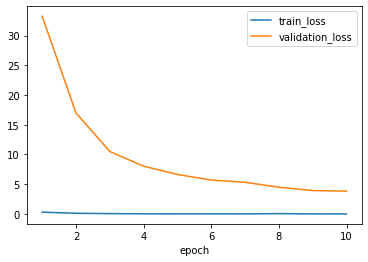

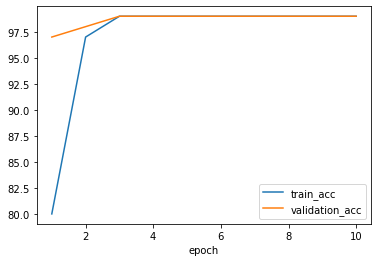

In [3]:
import torch.optim as optimizer
import time
time_start = time.time()
#https://www.codetd.com/article/8155853

optimizer = optimizer.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
period_epochs = 10

history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }
#loss = 0
def train(epoch):
    model.train()
    total_1epoch_traintime = 0
    loss, acc = 0, 0
    
    for batch_idx, (image, label) in enumerate(train_loader):
        time_train_1step_start = time.time()
        #image, label = Variable(image), Variable(label)
        image, label = Variable(image).cuda(), Variable(label).cuda()
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        acc += pred.eq(label.data.view_as(pred)).long().cpu().sum()

        time_train_1step_end = time.time()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} 1steptime:{:.4f} s'.format(
            epoch, batch_idx * len(image), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data, time_train_1step_end -  time_train_1step_start))
        
        total_1epoch_traintime += time_train_1step_end -  time_train_1step_start
    print(str(total_1epoch_traintime)+" s / epochs")
    history['train_loss'].append(loss)
    history['train_acc'].append(100*acc/len(train_loader.dataset))
    

def validation():
    model.eval()
    val_loss, correct = 0, 0

    total_1epoch_testtime = 0
    for (image, label) in val_loader:
        time_test_1step_start = time.time()
        image, label = Variable(image.float(), volatile=True).cuda(), Variable(label).cuda()
        output = model(image)
        #test_loss += criterion(output, label).data[0] # sum up batch loss
        val_loss += criterion(output, label).data # That's because in PyTorch>=0.5, the index of 0-dim tensor is invalid.
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(label.data.view_as(pred)).long().cpu().sum()
        
        #test_loss /= len(val_loader.dataset)
        time_test_1step_end = time.time()
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) 1steptime:{:.4f} s\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset), time_test_1step_end -  time_test_1step_start))
        
        total_1epoch_testtime += time_test_1step_end - time_test_1step_start
    print(str(total_1epoch_testtime)+" s / epochs")
    history['val_loss'].append(val_loss)
    history['val_acc'].append(100*correct/len(val_loader.dataset))

if flag_train == True:
    # Training
    time_start_training = time.time()
    for epoch in range(1, total_epochs + 1):
        time_start_training2 = time.time()
        train(epoch)
        validation()
        time_end_training2 = time.time()
        print(time_end_training2-time_start_training2)
        # Save Weights
        if epoch % period_epochs == 0:
            path_weights = "weights_pytorch/"+type_backbone+"/model"+str(epoch).zfill(4)+".pth"
            torch.save(model.state_dict(), path_weights)
        
    time_end_training = time.time()
    print(time_end_training - time_start_training )
    plt.figure()
    plt.plot(range(1, total_epochs+1), history['train_loss'], label='train_loss')
    plt.plot(range(1, total_epochs+1), history['val_loss'], label='validation_loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(output_folder+"/graph_loss.png")
    plt.show()
    
    plt.plot(range(1, total_epochs+1), history['train_acc'], label='train_acc')
    plt.plot(range(1, total_epochs+1), history['val_acc'], label='validation_acc')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(output_folder+"/graph_acc.png")
    plt.show()
    
elif flag_train == False:
    #Load weights
    weights_folder_path = "weights_pytorch/"+type_backbone
    files = os.listdir(weights_folder_path)
    best_weights_path = max(files)
    param = torch.load(weights_folder_path + "/" + best_weights_path)
    model.load_state_dict(param, strict=False)
    print("model loaded: "+weights_folder_path + "/" + best_weights_path)
    model.eval()

{'HookWrench': 0, 'SpannerWrench': 1}
[[ 1.9300177 -1.5774153]]
0 0
The above image is predicted as HookWrench
[[ 2.105277  -1.4272046]]
0 0
The above image is predicted as HookWrench
[[-2.7216074  3.1154983]]
1 1
The above image is predicted as SpannerWrench
[[-2.4703393  2.8063672]]
1 1
The above image is predicted as SpannerWrench


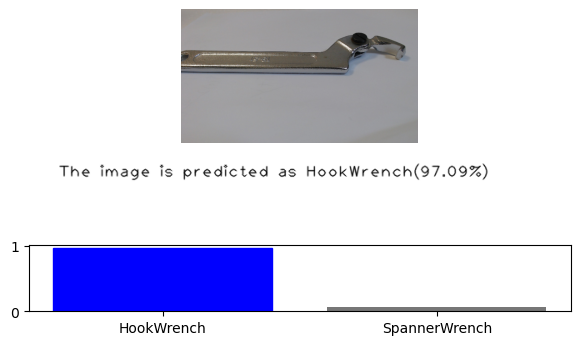

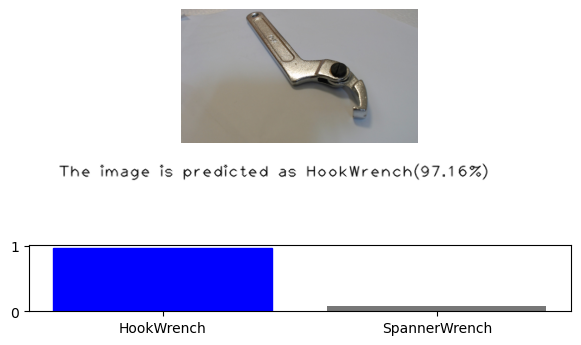

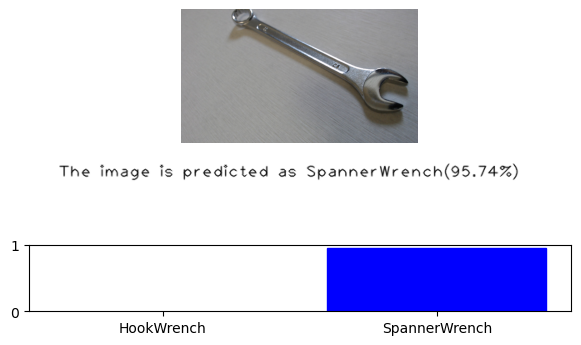

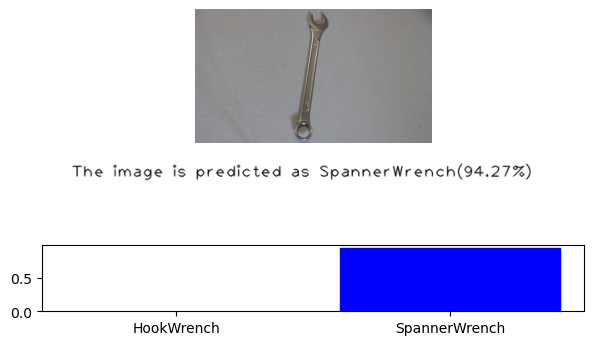

In [4]:
# Inference test images
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import math

k = 1

transform = transforms.Compose([transforms.Resize((img_size[0], img_size[1])), transforms.ToTensor()])
dataset_test = ImageFolder("test", transform)
test = DataLoader(dataset_test, batch_size=1, shuffle=False)

dict_class_idx = dataset_test.class_to_idx
print(dataset_test.class_to_idx)

for batch_idx, (image, label) in enumerate(test):
    #image, label = Variable(image), Variable(label)
    image, label = Variable(image).cuda(), Variable(label).cuda()

    i = dataset_test.imgs[batch_idx][0]

    true_label = dataset_test.imgs[batch_idx][1]

    with torch.no_grad():
        probs_pred = model(image)
        probs_pred = probs_pred.data.cpu().numpy()
        pred_classes = np.argmax(probs_pred, axis = 1)
        print(probs_pred)

    for q in range(len(probs_pred[0])):
        probs_pred[0][q] = math.exp(probs_pred[0][q])/sum([math.exp(p) for p in probs_pred[0]])

    predictions_array, true_label =  probs_pred[0], int(true_label)

    predicted_label = np.argmax(predictions_array)
    print(true_label, predicted_label)

    test_img = cv2.imread(i)
    blank_img = np.full((80, 600, 3), (255, 255, 255), dtype=np.uint8)

    text_show = "The image is predicted as "+str(categories[predicted_label]) +"("+str(round(float(max(predictions_array)*100), 2))+"%)"
    cv2.putText(blank_img, text_show, (10, 20), cv2.FONT_HERSHEY_PLAIN, 1.3, (0, 0, 0), 1, cv2.LINE_AA)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

    #img_v_concat = cv2.vconcat([np.asarray(blank_img),np.asarray(test_img)])

    fig = plt.figure(figsize = (7,4), dpi= 100)

    gs_master = GridSpec(nrows = 3, ncols = 1, height_ratios = (2,1,1))
    gs = [0]*3
    gs[0] = GridSpecFromSubplotSpec(nrows = 1, ncols = 1, subplot_spec = gs_master[0, 0:1])
    gs[1] = GridSpecFromSubplotSpec(nrows = 2, ncols = 1, subplot_spec = gs_master[1, 0])
    gs[2] = GridSpecFromSubplotSpec(nrows = 3, ncols = 1, subplot_spec = gs_master[2, 0])
    ax = [0]*3
    for j in range(len(gs)):
        ax[j] = fig.add_subplot(gs[j][:,:])

    #ax[0].imshow(np.asarray(img_v_concat))
    ax[0].imshow(np.asarray(test_img))
    ax[0].axis('off')

    ax[1].imshow(np.asarray(blank_img))
    ax[1].axis('off')

    thisplot = ax[2].bar(categories, predictions_array, color="#777777")
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

    plt.savefig(output_folder+"/"+str(k) + 'figure.png')
    print("The above image is predicted as " + categories[predicted_label])
    #plt.show()

    k += 1

ResNetの実行ではMemory 16GBでVRAM 6GBはないときついです。実行時にメモリ使用量が10GB以上になっていました。

以下はdataset_valのデータをdatasetに統合するプログラムなので、必要な時以外に実行しないでください。   
Don't use the next cell except merging dataset_val and dataset

In [3]:
# Revert Dataset (dataset & dataset_val -> dataset)
import os
import glob
import shutil
#categories = [i for i in os.listdir(os.getcwd().replace("/mylib", "") + "/dataset")]
categories = [i for i in os.listdir(os.getcwd()+ "/dataset")]
print(categories)
dirname_dataset = "dataset"# dataset folder
dirname_dataset_val = dirname_dataset + "_val" # validation dataset folder

def revert_dataset_val():
    '''
    Revert Dataset
    This function revert splitted validation dataset directory to dataset directory
    '''
    for j in categories:
        if os.path.exists(dirname_dataset_val  + "\\" + str(j) ) == True:
            files = glob.glob(dirname_dataset_val + "\\" + str(j) + "/*")
            for imgfile in files:
                shutil.move(imgfile, dirname_dataset + "\\" + str(j))
    if os.path.exists(dirname_dataset_val) == True:
        shutil.rmtree(dirname_dataset_val)
revert_dataset_val()

['HookWrench', 'SpannerWrench']
